In [262]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [263]:
data = pd.read_csv("NewApplications_Lender1_Round1.csv", index_col="id")
past_data = pd.read_csv("PastLoans.csv")

In [264]:
past_data = pd.get_dummies(past_data, columns=['employment'], drop_first=True)

sex_mapping = {'M': 1, 'F': 0}

past_data['sex'] = past_data['sex'].map(sex_mapping)

In [265]:

X = past_data.drop(columns=["default"])  # problem: we only have digital1 in the new data, but using only that the predicitons are not good, maybe try extrapolating/predicting digital2 and digital3 from the data
y = past_data['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# trying without setting the random state the results are not consistent at all, high variance in pnl
# maybe can try simulating a high number of times to check VaR and confidence, but mostly useful for report rather than pred
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [266]:

y_probs = model.predict_proba(X_test)[:, 1]

# can change the threshold to look at different profit scenarios, represents the maximum default risk we take
threshold = 0.03
y_pred = (y_probs >= threshold).astype(int)

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.97      0.31      0.48     18011
           1       0.13      0.92      0.23      1989

    accuracy                           0.37     20000
   macro avg       0.55      0.62      0.35     20000
weighted avg       0.89      0.37      0.45     20000

ROC AUC Score: 0.7114472165339772


In [267]:
premium = 0.02
min_rate = 0.01

preds = pd.DataFrame()
preds["PD"] = y_probs
preds["Pred"] = y_pred
preds["Real"] = y_test.values
preds["Rate"] = np.maximum(min_rate, preds["PD"] / (1 - preds["PD"])) + premium

In [268]:
accepted = preds[preds["Pred"] == 0]

gain = accepted.loc[accepted["Real"] == 0, "Rate"].sum() * 10000
loss = len(accepted[accepted["Real"] == 1]) * 10000
pnl = gain - loss

Estimated profit (assuming we got all the applicants we predicted not to default): 212636.69061061647


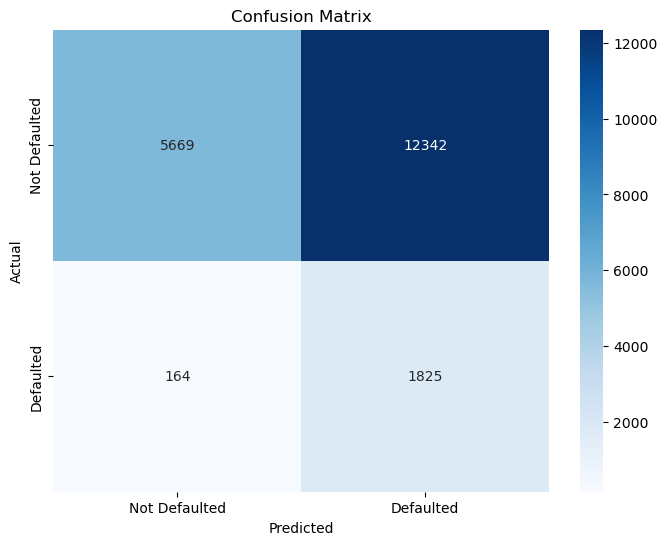

In [269]:
cm = confusion_matrix(y_test, y_pred)

print("Estimated profit (assuming we got all the applicants we predicted not to default):", pnl)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Defaulted', 'Defaulted'], 
            yticklabels=['Not Defaulted', 'Defaulted'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()